In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

In [53]:
df = pd.read_csv("hitters.csv")

In [6]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [8]:
df.shape

(322, 20)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,322.0,380.928571,153.404981,16.0,255.25,379.5,512.00,687.0
Hits,322.0,101.024845,46.454741,1.0,64.00,96.0,137.00,238.0
HmRun,322.0,10.770186,8.709037,0.0,4.00,8.0,16.00,40.0
Runs,322.0,50.909938,26.024095,0.0,30.25,48.0,69.00,130.0
RBI,322.0,48.027950,26.166895,0.0,28.00,44.0,64.75,121.0
Walks,322.0,38.742236,21.639327,0.0,22.00,35.0,53.00,105.0
Years,322.0,7.444099,4.926087,1.0,4.00,6.0,11.00,24.0
CAtBat,322.0,2648.683230,2324.205870,19.0,816.75,1928.0,3924.25,14053.0
CHits,322.0,717.571429,654.472627,4.0,209.00,508.0,1059.25,4256.0
CHmRun,322.0,69.490683,86.266061,0.0,14.00,37.5,90.00,548.0


In [93]:
print("Eksik değerler:")
print(df.isnull().sum())

Eksik değerler:
AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64


In [57]:
df['Salary'] = np.log1p(df['Salary'])

In [91]:
label_encoders = {}
categorical_features = ['League', 'Division', 'NewLeague']
for col in categorical_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

In [61]:
df = df.astype(float)

In [87]:
for col in numerical_features:
    Q1 = df[col].quantile(0.10)  
    Q3 = df[col].quantile(0.90)  
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [89]:
df.shape

(261, 20)

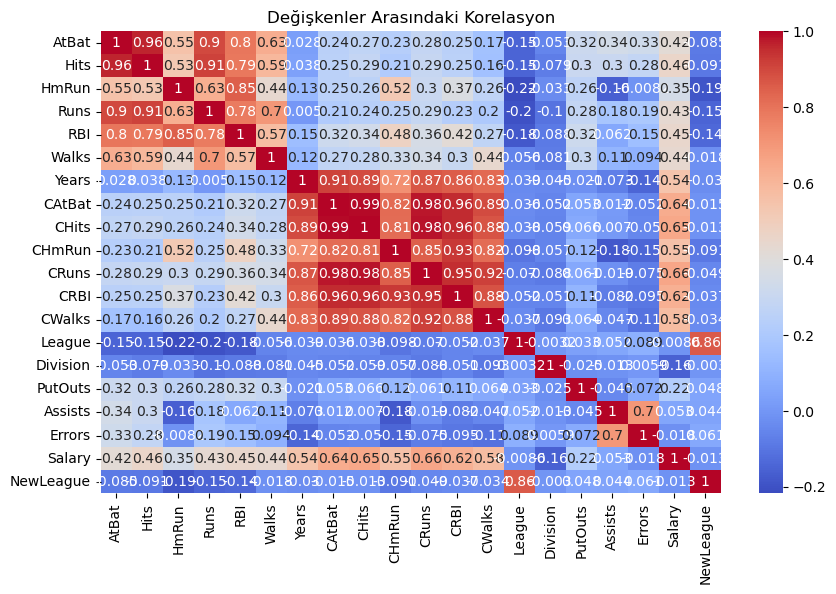

In [65]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Değişkenler Arasındaki Korelasyon")
plt.show()

In [67]:
corr_matrix = df.corr()['Salary'].abs().sort_values(ascending=False)
selected_features = corr_matrix[corr_matrix > 0.2].index.tolist()
selected_features.remove('Salary')

In [71]:
categorical_features = [col for col in categorical_features if col in selected_features]
numerical_features = [col for col in selected_features if col not in categorical_features]

In [73]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

if not categorical_features:
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, numerical_features)]
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

In [75]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

X = df[selected_features]
y = df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
tuned_parameters = {
    'Random Forest': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__kernel': ['linear', 'rbf']
    }
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    if name in tuned_parameters:
        random_search = RandomizedSearchCV(pipeline, tuned_parameters[name], cv=5, scoring='neg_mean_squared_error', n_iter=10, random_state=42)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)
    else:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f'{name} Modeli - MSE: {mse}, MAE: {mae}, R²: {r2}')

Linear Regression Modeli - MSE: 0.26888595839091445, MAE: 0.45032102372045557, R²: 0.6900703842844313


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random Forest Modeli - MSE: 0.1293178513708686, MAE: 0.26738698977472325, R²: 0.8509426367208524


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Gradient Boosting Modeli - MSE: 0.11309492038381598, MAE: 0.2450602561493038, R²: 0.8696418904739531


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVR Modeli - MSE: 0.1614533373259511, MAE: 0.287327075803256, R²: 0.8139018820734415


In [79]:
best_model = max(results, key=lambda x: (results[x]['R2'], -results[x]['MSE'], -results[x]['MAE']))
print(f'En iyi model: {best_model} (MSE: {results[best_model]["MSE"]}, MAE: {results[best_model]["MAE"]}, R²: {results[best_model]["R2"]})')

En iyi model: Gradient Boosting (MSE: 0.11309492038381598, MAE: 0.2450602561493038, R²: 0.8696418904739531)


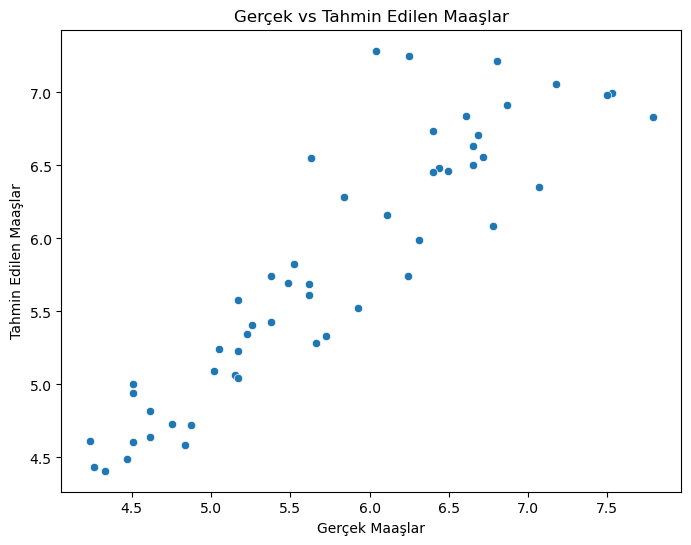

In [81]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Gerçek Maaşlar")
plt.ylabel("Tahmin Edilen Maaşlar")
plt.title("Gerçek vs Tahmin Edilen Maaşlar")
plt.show()

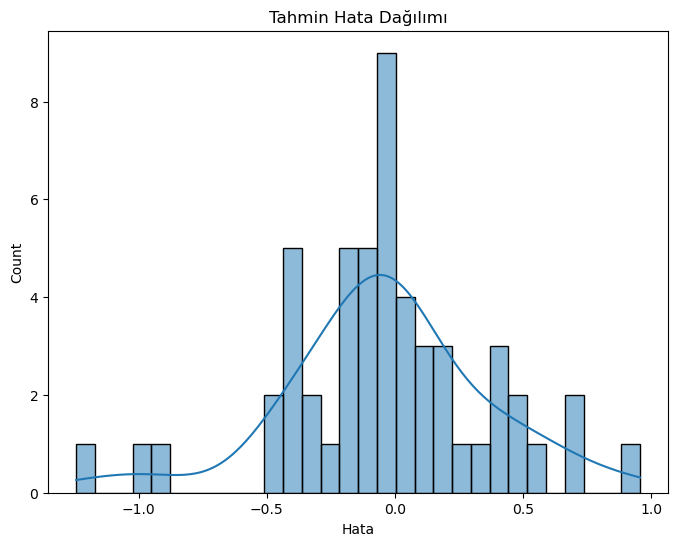

In [83]:
errors = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel("Hata")
plt.title("Tahmin Hata Dağılımı")
plt.show()

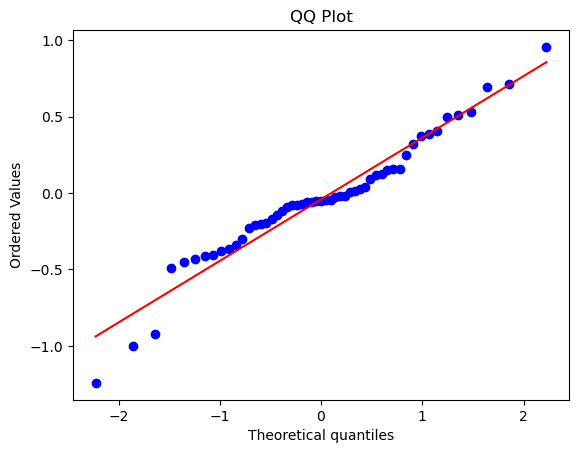

In [85]:
stats.probplot(errors, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()